In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



In [10]:
names


array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [11]:
print(data[6])


T90 = np.array(data[6], dtype = float)

ra = np.array(data[3], dtype = float)

decl = np.array(data[4], dtype = float)

fluence = np.array (data[9], dtype = float)

z =  np.array(data[11], dtype = float)   # we don't know selection effects of long gamma ray burst... 

T100 =  np.array(data[12], dtype = float)

#print(data[13])

['2.0480' '37.3770' '42.7530' ... '3.1360' '208.5760' '5.1840']


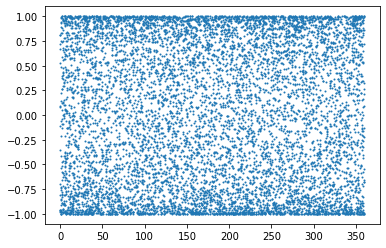

In [12]:
plt.scatter(ra, np.cos(decl), s= 1)
plt.show()

plt.scatter(ra, np.cos(decl), s= 1)
plt.show()

In [14]:
T90_mask = T90 > 0
fluence_mask = fluence > 0
mask = T90_mask & fluence_mask

T90_masked = np.array( T90[mask], dtype = float)
fluence_masked = np.array(fluence[mask], dtype = float)

In [15]:
print(fluence)

[5.7502e-07 5.8068e-06 3.3510e-06 ... 2.4858e-08 1.6510e-07 2.6055e-06]


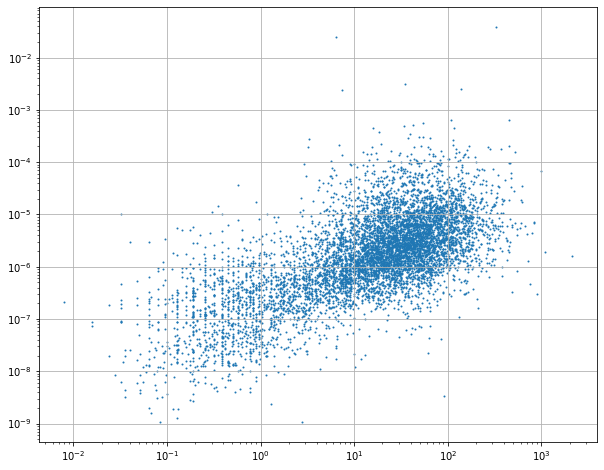

In [16]:
plt.figure(figsize = (10,8))
plt.scatter(T90[mask], fluence[mask], s= 1)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.show()

[[  0.71686371 -14.36886101]
 [  3.62105554 -12.05648091]
 [  3.75543937 -12.60625175]
 ...
 [  1.1429481  -17.5100862 ]
 [  5.34030348 -15.61671449]
 [  1.64557696 -12.85788596]]
CLUSTER CENTERS: [[  3.52183253 -12.57130246]
 [  0.17229146 -15.48111591]]


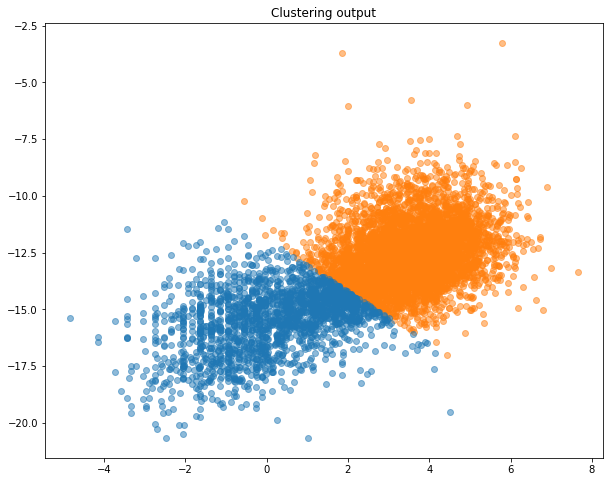

In [18]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

X = np.array([np.log(T90_masked), np.log(fluence_masked)]).T
print(X)


clf = KMeans(n_clusters=2) #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

plt.figure(figsize = (10,8))

# plot the data color-coded by cluster id
colors = ['C1', 'C0', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5)

# To get some information on these try:
# KMeans?
# help(clf)

#plt.xscale('log')
#plt.yscale('log')
plt.title('Clustering output');

print("CLUSTER CENTERS:", centers)

## plot the histogram of T90, use KDE

### clustering maybe too data driven, try and see gaussian mixture and get the means, is it near the cluster centers?

In [22]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift

scaler = preprocessing.StandardScaler()
bandwidth = 0.4
#bandwidth = estimate_bandwidth(X_reduced) # this takes a long time...beware
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(X))

MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23]
0.4
number of estimated clusters : 24


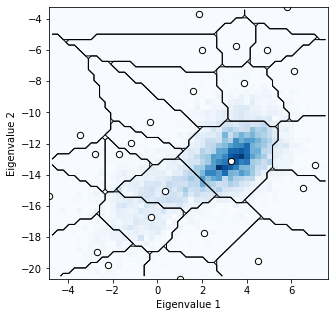

In [23]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()

# to account ofr errors one could run an mcmc (?)